Variant: 3 (27) <br>
NN architecture: AlexNet <br>
Dataset: Cifar10 <br>
link to dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Imports

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import random
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Oleksiy\anaconda3\envs\main_AI\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [36]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setting random number seed

In [9]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
torch.use_deterministic_algorithms(True)

In [10]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator()
g_test = torch.Generator()
g_train.manual_seed(0)
g_test.manual_seed(1)

### Data read

In [37]:
# Create sequence of transformations: data -> tensor -> (tensor - mean) / std
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Number of images in each batch, reccomended to == 2^n
batch_size = 32

# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
# Create a sampler, that provides an iterable over the trainset
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
# Create a sampler, for testset
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In this lab work we don't perform hyperparameter tuning, as a result we split data only into train/test sets and therefore don't use validation set (test set plays his role).

### Data visualization

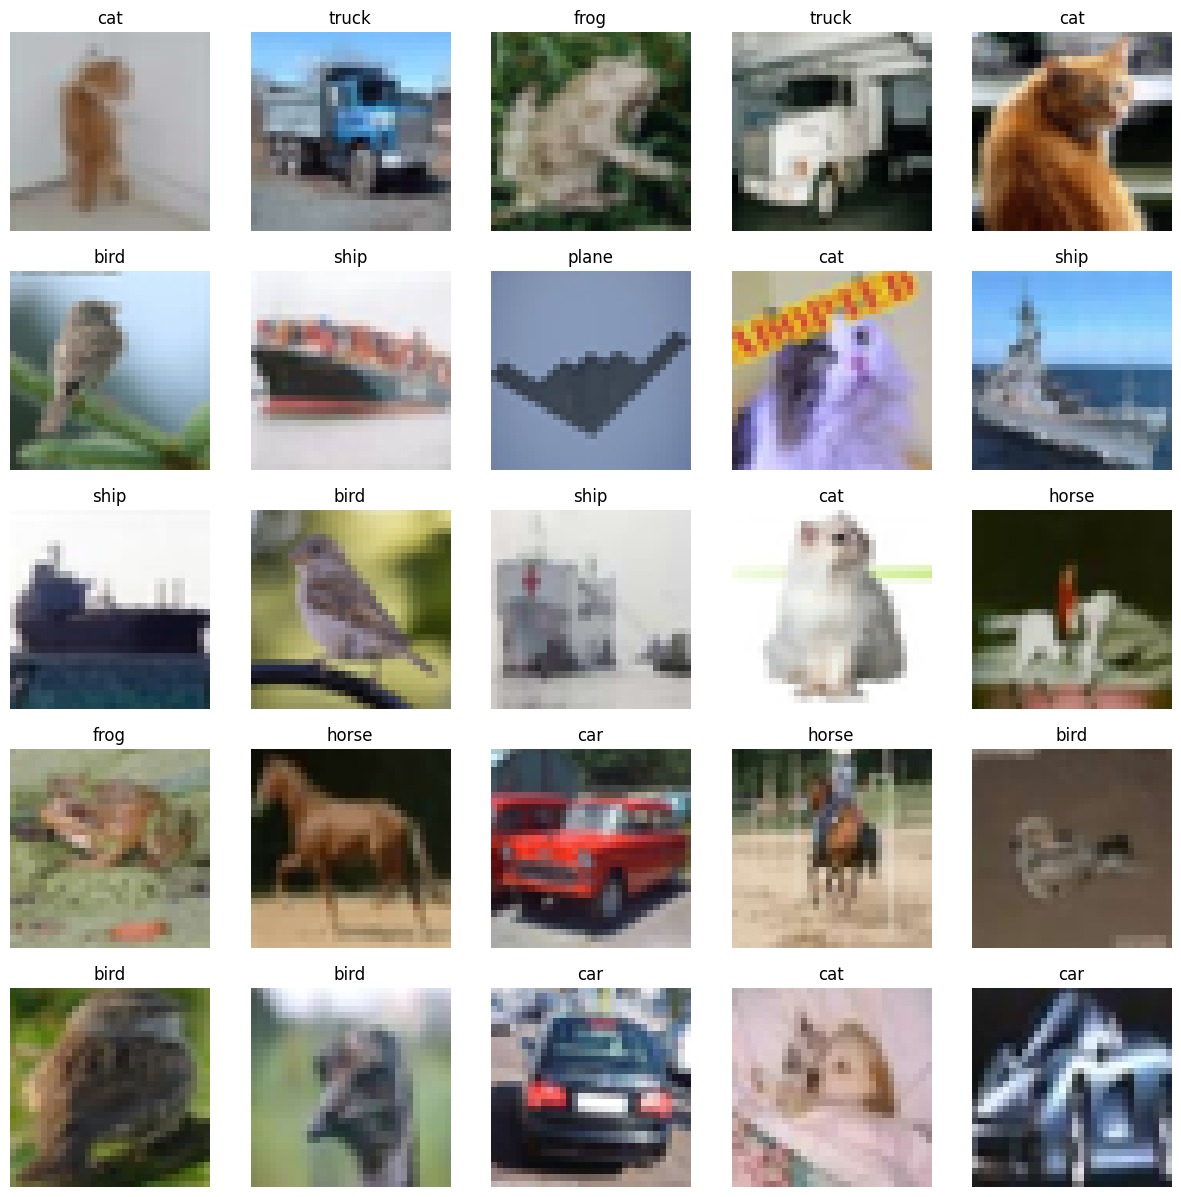

In [40]:
def imshow(img):
    # Unnormalize image (-1, 1) -> (0, 1)
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(1, rows * cols + 1):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

### Neural network setup

In [42]:
alexnet = models.alexnet(num_classes=10)

criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes))
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

### Network training

In [ ]:
# Set the number of epochs
epochs = 3

cycle = 250
train_data_len = len(trainloader)
checks_per_train = int(train_data_len / (cycle * batch_size))
train_loss_arr = np.zeros(checks_per_train * epochs)
test_data_len = len(testloader)
checks_per_test = int(test_data_len / (cycle * batch_size))
test_loss_arr = np.zeros(checks_per_test * epochs)
test_accuracy_arr = np.zeros(checks_per_test * epochs)

# Create training and testing loop
for epoch in range(epochs):
    dataiter = iter(testloader)
    print(f"Current epoch: {epoch}\n-------")
    # Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch_num, (tr_inputs, tr_labels), (tst_inputs, tst_labels) in zip(enumerate(trainloader), testloader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet(tr_inputs)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss
        
        # Test loss and accuracy calculation
        predictions = alexnet(tst_inputs)
        test_loss += criterion(predictions, tst_labels)
        test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
        
        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle == 0:
            print(f"Looked at {batch_num * batch_size} samples")
            # Save loss for current batch
            ind = checks_per_train * epoch + int(batch_num / cycle)
            train_loss_arr[ind] = train_loss
            test_loss_arr[ind] = test_loss
            test_accuracy_arr[ind] = test_acc
            train_loss = test_acc = test_loss = 0

    ## Print out this epoch
    print(f"\nAverage train loss: {train_loss:.5f} | Average test loss: {test_loss:.5f}, Average test acc: {test_acc:.2f}%\n")